In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import matplotlib.patches
from scipy.stats import zscore
from sklearn.decomposition import NMF, PCA
import pyjags

In [2]:
# load data
with open('data/mouse_set_1_data.pkl', 'rb') as handle:
    mouse_set_1 = pickle.load(handle) 

In [3]:
# unfold data
reads = mouse_set_1['reads']
qpcr = mouse_set_1['qpcr']
otu_taxonomy = mouse_set_1['otu_taxonomy']
times = mouse_set_1['times']

In [4]:
# perturbation time periods
high_fat = [22,28.5]
gram_pos = [36,42.5]
gram_neg = [51,57.5]

In [5]:
# organize mouse 2
mouse_id = '2'
mouse_reads_df = reads[mouse_id]
m_total_amount = qpcr[mouse_id]['mean'].values
all_OTU = list(mouse_reads_df.index)

m_reads_values=reads[mouse_id].values
m_reads_values_sum=sum(m_reads_values)

m_all_abs_amount = np.zeros((len(all_OTU), len(times)))
for idx, otu in enumerate(all_OTU):
    these_reads = mouse_reads_df.loc[otu]
    this_relative_abundance = these_reads.values/m_reads_values_sum
    this_abs_abundance = this_relative_abundance * m_total_amount
    
    m_all_abs_amount[idx,:] = this_abs_abundance
    
m_all_abs_amount_z = zscore(m_all_abs_amount, axis = 1)

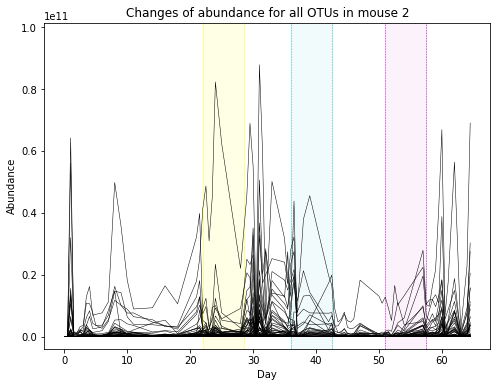

In [6]:
fig,ax = plt.subplots(1,1,figsize = (8,6))
ax.plot(times, m_all_abs_amount.T, linewidth = 0.5, c='k');

y1,y2 = ax.get_ylim()
ax.vlines(x = high_fat, ymin = y1*0.9, ymax = y2*1.1, color = 'yellow', linewidth = 0.5, linestyle = '--')
ax.vlines(x = gram_pos, ymin = y1*0.9, ymax = y2*1.1, color = 'c', linewidth = 0.5, linestyle = '--')
ax.vlines(x = gram_neg, ymin = y1*0.9, ymax = y2*1.1, color = 'm', linewidth = 0.5, linestyle = '--')

rect1 = matplotlib.patches.Rectangle((high_fat[0],y1*0.9), high_fat[1]-high_fat[0],y2*1.1-y1*0.9, 
                                     color='yellow',alpha = 0.1)
rect2 = matplotlib.patches.Rectangle((gram_pos[0],y1*0.9), gram_pos[1]-gram_pos[0],y2*1.1-y1*0.9, 
                                     color='c',alpha = 0.05)
rect3 = matplotlib.patches.Rectangle((gram_neg[0],y1*0.9), gram_neg[1]-gram_neg[0],y2*1.1-y1*0.9, 
                                     color='m',alpha = 0.05)
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.set_ylim([y1*0.9, y2*1.1])
ax.set(xlabel='Day', ylabel = 'Abundance', title = 'Changes of abundance for all OTUs in mouse 2');

#### Pyjags code

Priors that we have to set: 
- alpha (dgamma)
- sig_b_2_inv 
- sig_a_2_inv
- sig_w_2_inv
- sig_q_2_inv
I set the above 4 priors to be dgamma(0.1,0.1), corresponding to flat prior...but I think there will be a better way to set them.

a0, a_1 are the parameters for negBino dispersion scaling parameters. In the paper section 2.4, they said they "pre-trained on raw data" to get these values, but I don't know how that works...will have to check with the professors.

There are 3 extra major things about the model:

1. I don't understand how the model can constrain x and q to be non-negative. q is used in the generative process of y, and they must be positive to be plug in the negBino distribution.

2. For the negBino distribution that generates y, the parameter phi has to be an non-negative integer (right?). I don't think it is the case in the model right now.

3. I think in the paper they break down the MCMC into separate steps and some of them can be expressed in closed-form solutions to speed up the process. I don't know how pyjags do the sampling but I think it's taking really long...






In [11]:
modelString = """
model{
    
    # Dirichlet process
    # stick breaking 
    for (clus in 1:C){alpha[clus] ~ dgamma(1,1)}
    pi[1:C] ~ ddirch(alpha[1:C])
    
    # multinomial draw for cluster assignment
    for (i in 1:N){
        c[i] ~ dcat(pi[1:C]);
    }    
    
    # interaction between clusters
    sig_b_2_inv ~ dgamma(0.1,0.1);   # I don't know what prior we should use
    sig_b = sqrt(1/sig_b_2_inv);
    
    for (i in 1:C){
        for (j in 1:C){
            this_b[i,j] ~ dnorm(0, sig_b_2_inv);
            b[i,j] = ifelse(i==j, 0, this_b[i,j]);
        }
    }
    
    # Edge selection
    pi_z ~ dunif(0,1)
    for (i in 1:C){
        for (j in 1:C){
            z[i,j] ~ dbern(pi_z);
        }
    }
    
    # Self interaction
    sig_a_2_inv ~ dgamma(0.1,0.1);   # I don't know what prior we should use
    sig_a = sqrt(1/sig_a_2_inv);
    
    for (i in 1:N){
        a1[i] ~ dnorm(0,sig_a_2_inv);
        a2[i] ~ dnorm(0,sig_a_2_inv);
    }
    
    # Dynamics
    # set up priors
    sig_w_2_inv ~ dgamma(0.1,0.1);   # I don't know what prior we should use
    sig_w = sqrt(1/sig_w_2_inv);
    
    # initialize x[k=1, i]
    for (i in 1:N){
        x[1,i] ~ dnorm(0, sig_w_2_inv);
    }
    
    # initialize bzx[k=1,i,j] (this is the first term for interaction term in main dynamics)
    for (i in 1:N){
        for (j in 1:N){
            bzx[1,i,j] = 0;
        }
    }
    
    # prior for effect of each perturbation
    for (i in 1:N){
        P_fat[i] ~ dnorm(0,0.0001);
        P_pos[i] ~ dnorm(0,0.0001);
        P_neg[i] ~ dnorm(0,0.0001);
    }
    
    # main dynamics  (I have to pull out the interaction term bzx in an extra loop since pyjags doesn't to element-wise multiplication)
    for (k in (2:K)){
        for (i in 1:N){
            for (j in 1:N){
                bzx[k,i,j] = b[c[i],c[j]]*z[c[i],c[j]]*x[k-1,j];
            }
            x[k,i] ~ dnorm(x[k-1,i] + x[k-1,i]*(a1[i] + a2[i]*x[k-1,i] + sum(bzx[k,i,]) + fat[k-1]*P_fat[i] + pos[k-1]*P_pos[i] + neg[k-1]*P_neg[i]), sig_w_2_inv/(times[k]-times[k-1]));
        }
    }
    
    # constrain and measurement model
    sig_q_2_inv ~ dgamma(20,1000);   # try to use a small variance
    sig_q = sqrt(1/sig_q_2_inv);
    
    # compute auxillary variable q        
    for (k in 1:K){
        for (i in 1:N){
            q[k,i] ~ dnorm(x[k,i], sig_q_2_inv);   # plug in the variance of q     
        }
    }

    # compute phi and eps as parameters for negBino distribution
    for (k in 1:K){
        for (i in 1:N){
            phi[k, i] = r[k]*(q[k,i]/sum(q[k, ]));
            eps[k, i] = a0/(q[k,i]/sum(q[k, ])) + a_1;
        } 
    }

    # compute reads y
    for (k in 1:K){
        for (i in 1:N){
            y[k,i] ~ dnegbin(phi[k,i], eps[k,i]);
        }
    }

    # compute qPCR amount Q
    for (k in 1:K){
        Q[k] ~ dnorm(sum(q[k, ]), 1/pow(sigma_Q,2));
    }
}"""

(202, 75) (75,)
(75, 202) (75,) (75,)


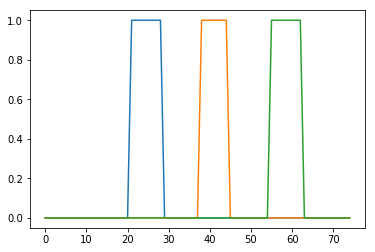

In [12]:
# prepare input to sampler (only using mouse 2 data)

print(m_reads_values.shape, m_total_amount.shape)

y = m_reads_values.T   # reads for every OTU at each timepoint (K x N)
Q = m_total_amount     # qPCR amount for every timepoint
r = np.sum(m_reads_values, axis = 0)   # total reads for every timepoint

print(y.shape, Q.shape, r.shape)

# prepare perturbation as dummy variables
is_high_fat = np.logical_and(np.array(times)>=high_fat[0], np.array(times)<high_fat[1]) 
is_gram_pos = np.logical_and(np.array(times)>=gram_pos[0], np.array(times)<gram_pos[1]) 
is_gram_neg = np.logical_and(np.array(times)>=gram_neg[0], np.array(times)<gram_neg[1]) 

plt.plot(is_high_fat)
plt.plot(is_gram_pos)
plt.plot(is_gram_neg)

In [ ]:
observed_vals = {'r': r,
                 'y': y,
                 'Q': Q,
                 'fat': is_high_fat,
                 'pos': is_gram_pos,
                 'neg': is_gram_neg,
                 'a0': 0.0025,
                 'a_1': 0.025,
                 'N': y.shape[1],
                 'C': 6,
                 'K': y.shape[0],
                 'sigma_Q': np.var(Q),
                 'times':times}

num_chains = 4

model = pyjags.Model(modelString, data=observed_vals, chains=num_chains)
burnin = model.sample(500)
samples = model.sample(2000)

In [14]:
simplifiedModel = """
model{
    
    # Dirichlet process
    # stick breaking 
    for (clus in 1:C){alpha[clus] ~ dgamma(1,1)}
    pi[1:C] ~ ddirch(alpha[1:C])
    
    # multinomial draw for cluster assignment
    for (i in 1:N){
        c[i] ~ dcat(pi[1:C]);
    }    
    
    # interaction between clusters
    sig_b_2_inv ~ dgamma(0.1,0.1);   # flat prior
    sig_b = sqrt(1/sig_b_2_inv);
    
    for (i in 1:C){
        for (j in 1:C){
            this_b[i,j] ~ dnorm(0, sig_b_2_inv);
            b[i,j] = ifelse(i==j, 0, this_b[i,j]);
        }
    }
    
    # Edge selection
    pi_z ~ dunif(0,1)
    for (i in 1:C){
        for (j in 1:C){
            z[i,j] ~ dbern(pi_z);
        }
    }
    
    # Self interaction
    sig_a_2_inv ~ dgamma(0.1,0.1);   # flat prior
    sig_a = sqrt(1/sig_a_2_inv);
    
    for (i in 1:N){
        a1[i] ~ dnorm(0,sig_a_2_inv);
        a2[i] ~ dnorm(0,sig_a_2_inv);
    }
    
    # Dynamics
    # set up priors
    sig_w_2_inv ~ dgamma(0.1,0.1);   # flat prior
    sig_w = sqrt(1/sig_w_2_inv);
    
    # initialize bzx[k=1,i,j] (this is the first term for interaction term in main dynamics)
    for (i in 1:N){
        for (j in 1:N){
            bzx[1,i,j] = 0;
        }
    }
    
    # main dynamics  (I have to pull out the interaction term bzx in an extra loop since pyjags doesn't to element-wise multiplication)
    for (k in (2:K)){
        for (i in 1:N){
            for (j in 1:N){
                bzx[k,i,j] = b[c[i],c[j]]*z[c[i],c[j]]*x[k-1,j];
            }
            # truncated normal
            x[k,i] ~ dnorm(x[k-1,i] + x[k-1,i]*(a1[i] + a2[i]*x[k-1,i] + sum(bzx[k,i,])), sig_w_2_inv/(times[k]-times[k-1]))T(0,);
        }
    }
    
}"""

In [17]:
observed_vals = {'x': m_all_abs_amount[:10,:22].T,
                 'N': 10,
                 'C': 3,
                 'K': 22,
                 'times':times[:22]}

num_chains = 4

model = pyjags.Model(simplifiedModel, data=observed_vals, chains=num_chains)
burnin = model.sample(500)
samples = model.sample(2000)

adapting: iterations 4 of 4000, elapsed 0:00:01, remaining 0:17:00


JagsError: Error in node alpha[3]
Slicer stuck at value with infinite density
